# LangGraph chain - Python Cookbook

### llm setup for LangChain

In [53]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash',temperature=0)


### tools

In [54]:
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

@tool
def get_weather(city: str, unit: str = 'celsius') -> str:
	"""Get the weather for a city."""
	return f"The weather in {city} is 25 degrees {unit}."

@tool
def web_search(query: str) -> str:
	"""Search the web for a query."""
	tavily_search_tool = TavilySearch(
		max_results=5,
		topic="general",
	)
	return tavily_search_tool.invoke(query)

TOOL_MAP = {
	"get_weather": get_weather,
	"web_search": web_search,
}

### Add tools to the llm

In [55]:
llm = llm.bind_tools([get_weather, web_search])

### State - Message from Langchain

### Reducers

##### What? - Reducers are functions to apply updates from nodes to state

In [56]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage

from langgraph.graph.message import add_messages # add_messages is the reducer to add messages to the state

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [57]:
# BTS of add_messages - reference: https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb 
from langchain_core.messages import AIMessage, HumanMessage

initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='4b079dc7-68b9-487e-8b57-9ca84712a0f4'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='b8dbd22b-d2a6-4087-983d-80a25b070d6a'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='fb8db46e-18e5-41ac-8351-66ef7971b136')]

### Node

In [63]:
from langchain_core.messages import ToolMessage

def main_node(state: MessagesState):
	llm_output = llm.invoke(state["messages"])
	
	updated_messages = state["messages"] + [llm_output]
	
	for tool_call in llm_output.tool_calls:
		tool = TOOL_MAP[tool_call["name"]]
		tool_output = tool.invoke(tool_call["args"])
		
		tool_message = ToolMessage(
			content=str(tool_output),
			tool_call_id=tool_call["id"]
		)
		updated_messages.append(tool_message)
	
	return {"messages": updated_messages}

### Build Graph

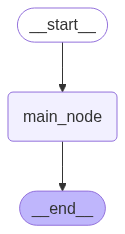

In [64]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


builder = StateGraph(MessagesState)
builder.add_node("main_node", main_node)
builder.add_edge(START, "main_node")
builder.add_edge("main_node", END)
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke Graph

#### a. simple message - requring no tools

In [66]:
messages = graph.invoke({"messages": [HumanMessage(content="What up!")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What up!
================================== Ai Message ==================================

Hello! How can I help you today?


#### b. tool calling - with weather tool

In [67]:
messages = graph.invoke({"messages": [HumanMessage(content="What is the weather in San Francisco?")]})
for m in messages['messages']:
	m.pretty_print()

================================ Human Message =================================

What is the weather in San Francisco?
================================== Ai Message ==================================
Tool Calls:
  get_weather (c23d68ba-b1f3-4384-a06a-e4b70a426442)
 Call ID: c23d68ba-b1f3-4384-a06a-e4b70a426442
  Args:
    city: San Francisco
================================= Tool Message =================================

The weather in San Francisco is 25 degrees celsius.


#### c. tool calling - with web_search tool

In [68]:
messages = graph.invoke({"messages": [HumanMessage(content="What is the current news in NY?")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the current news in NY?
================================== Ai Message ==================================
Tool Calls:
  web_search (429d6ed4-b664-438d-8f26-4143306ef57c)
 Call ID: 429d6ed4-b664-438d-8f26-4143306ef57c
  Args:
    query: current news in NY
================================= Tool Message =================================

{'query': 'current news in NY', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.nbcnewyork.com/', 'title': 'NBC 4 New York – NY local news, breaking news, weather', 'content': 'Find New York news and weather on NBC 4. NBC New York brings you breaking news alerts, local news and weather forecasts for NY and New Jersey.', 'score': 0.4485476, 'raw_content': None}, {'url': 'https://abc7ny.com/', 'title': 'ABC7 Eyewitness News - WABC-TV New York', 'content': "Girl injured in Harlem shooting reunites with officers who treated her 